In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import ast
import re
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models.word2vec import Word2Vec
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

The dataset has been previously labelled.

In [2]:
# Load the dataset from CSV file and show its head
df = pd.read_csv("/kaggle/input/vegan-dataset/vegan.csv")
df

,Unnamed: 0,title,ingredients,directions,link,source,NER,vegan
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu...",0
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom...",0
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar...",0
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo...",0
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu...",0
...,...,...,...,...,...,...,...,...
2231137,2231137,Sunny's Fake Crepes,"[""1/2 cup chocolate hazelnut spread (recommend...","[""Spread hazelnut spread on 1 side of each tor...",www.foodnetwork.com/recipes/sunny-anderson/sun...,Recipes1M,"[""chocolate hazelnut spread"", ""tortillas"", ""bu...",0
2231138,2231138,Devil Eggs,"[""1 dozen eggs"", ""1 paprika"", ""1 salt and pepp...","[""Boil eggs on medium for 30mins."", ""Then cool...",cookpad.com/us/recipes/355411-devil-eggs,Recipes1M,"[""eggs"", ""paprika"", ""salt"", ""choice"", ""miracle...",0
2231139,2231139,Extremely Easy and Quick - Namul Daikon Salad,"[""150 grams Daikon radish"", ""1 tbsp Sesame oil...","[""Julienne the daikon and squeeze out the exce...",cookpad.com/us/recipes/153324-extremely-easy-a...,Recipes1M,"[""radish"", ""Sesame oil"", ""White sesame seeds"",...",0
2231140,2231140,Pan-Roasted Pork Chops With Apple Fritters,"[""1 cup apple cider"", ""6 tablespoons sugar"", ""...","[""In a large bowl, mix the apple cider with 4 ...",cooking.nytimes.com/recipes/1015164,Recipes1M,"[""apple cider"", ""sugar"", ""kosher salt"", ""bay l...",0


In [3]:
# Randomly sample the dataset
df = df.sample(frac=0.25, random_state=42)

## Word2Vec Training

In [4]:
# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Convert the 'ingredients' column to a list of lists
w2v_ingredients = df['ingredients'].apply(ast.literal_eval)

# Initialize an empty list to store the cleaned data
tokenized_ingredients = []

for ingredient_list in w2v_ingredients:
    cleaned_list = []
    
    for ingredient in ingredient_list:
        # Remove punctuation and convert to lowercase
        ingredient = re.sub(r'[^\w\s]', '', ingredient).lower()
        # Remove numbers and words nearby (e.g., '200g', '5ml', etc.)
        ingredient = re.sub(r'\b\d+(\w+)?\b', '', ingredient)
        
        # Tokenize
        tokens = ingredient.split()

         # Remove stopwords and single-character tokens
        tokens = [word for word in tokens if word not in stop_words and len(word) > 1]

        # Add the cleaned tokens to the list
        cleaned_list.extend(tokens)

    # Append the cleaned list to the tokenized_ingredients list
    tokenized_ingredients.append(cleaned_list)

# Print a few samples to verify
print(tokenized_ingredients[:5])

[['pound', 'flank', 'steak', 'finely', 'minced', 'green', 'onions', 'scallions', 'dry', 'red', 'wine', 'soy', 'sauce', 'tbsp', 'salad', 'oil', 'teaspoon', 'sesame', 'seeds', 'teaspoon', 'packed', 'brown', 'sugar', 'teaspoon', 'grnd', 'black', 'pepper', 'teaspoon', 'grnd', 'ginger', 'clove', 'garlic', 'chopped'], ['tablespoon', 'rosemary', 'teaspoon', 'thyme', 'bay', 'leaves', 'teaspoon', 'smoked', 'paprika', 'teaspoon', 'pepper', 'cup', 'red', 'wine', 'cups', 'chicken', 'broth', 'cups', 'button', 'mushrooms', 'sliced', 'cups', 'mushroom', 'mix', 'oyster', 'shiitake', 'baby', 'bella', 'sliced', 'medium', 'carrots', 'sliced', 'diagonally', 'onion', 'medium', 'chopped', 'red', 'potato', 'medium', 'cut', 'pieces', 'cup', 'frozen', 'green', 'beans', 'pieces', 'black', 'olives', 'pitted', 'ripe', 'halved', 'handful', 'grape', 'tomatoes', 'halved', 'chicken', 'thighs', 'bones', 'skin', 'lbs', 'stalks', 'celery', 'cups', 'water'], ['carrots', 'tbsp', 'butter', 'brown', 'sugar', 'grated', 'lemo

In [6]:
# Train the Word2Vec model
model = Word2Vec(
    sentences=tokenized_ingredients, 
    vector_size=50, 
    window=5, 
    min_count=5, 
    sg=1,  # 1 for Skip-Gram, 0 for CBOW
    epochs=10
)

# Save the model for later use
model.save("w2v_model.model")

Now, we need to convert the ingredient lists into fixed-length vectors using the trained Word2Vec model. 

In [7]:
# Combine each ingredient list back into a single string for TF-IDF processing
corpus = [" ".join(ing) for ing in tokenized_ingredients]

# Compute TF-IDF scores
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

# Extract TF-IDF feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

In [8]:
# Create a dictionary with word-to-tfidf mapping
tfidf_dict = dict(zip(feature_names, tfidf_vectorizer.idf_))

In [9]:
def vectorize_ingredients_tfidf(ingredient_list, model, tfidf_dict):
    vectors = []
    weights = []
    
    for word in ingredient_list:
        if word in model.wv and word in tfidf_dict:
            # Get Word2Vec vector
            word_vec = model.wv[word]
            
            # Get TF-IDF weight
            weight = tfidf_dict[word]
            
            # Apply weighting
            vectors.append(word_vec * weight)
            weights.append(weight)
    
    # Handle cases with no matching words
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    
    # Calculate weighted average
    return np.average(vectors, axis=0, weights=weights)

In [10]:
# Apply TF-IDF weighted vectorization to the dataset
ingredient_vectors_tfidf = np.array([vectorize_ingredients_tfidf(ing, model, tfidf_dict) for ing in tokenized_ingredients])

print(f"Shape of ingredient vectors with TF-IDF weighting: {ingredient_vectors_tfidf.shape}")

Shape of ingredient vectors with TF-IDF weighting: (557786, 50)


## Train a classifier

In [11]:
y = df['vegan'].values
print(f"Number of vegan examples: {ingredient_vectors_tfidf[y == 1]}")
print(f"Number of non-vegan examples: {ingredient_vectors_tfidf[y == 0]}")

Number of vegan examples: [[ 1.32458484 -0.91651551 -0.33855809 ... -1.97300574  2.06789318
  -0.18402074]
 [ 1.14370916  0.00917713  0.13111977 ... -0.55755098 -0.17378235
   0.17226807]
 [ 1.28177571  0.17255336 -0.99914426 ... -1.01856643 -0.047168
   0.80455285]
 ...
 [ 1.05954487  0.20080097  0.0989337  ... -1.80113456  1.6657761
   1.04674359]
 [ 0.73365742 -0.18630368 -0.46531167 ... -2.59154531  1.89292355
   1.56091778]
 [ 1.01247177 -1.14533168 -0.96880242 ... -1.52879473  0.92112796
   0.21598872]]
Number of non-vegan examples: [[ 0.10029507 -0.44242416 -0.42462041 ... -1.27992647  1.04625799
   0.23011776]
 [ 0.56147917  0.15519166 -0.11813169 ... -2.28731034  2.283699
   0.61215164]
 [ 1.26853413 -0.45699335 -0.37749191 ... -0.5445405  -0.50587446
   0.48192087]
 ...
 [ 1.83487825 -0.77493648  0.61748989 ... -1.45674162  0.53849659
   3.60713775]
 [ 0.5195996  -0.84978844 -0.51853313 ... -1.22146873  1.71263754
   1.03241999]
 [ 1.4342246  -1.02246483 -0.26663505 ... -0.36

As we can see the dataset is highly unbalanced (as expected).

In [12]:
# Separate vegan and non-vegan samples
X_vegan = ingredient_vectors_tfidf[y == 1]
X_non_vegan = ingredient_vectors_tfidf[y == 0]

y_vegan = y[y == 1]
y_non_vegan = y[y == 0]

# Determine the smaller class size
min_samples = min(len(X_vegan), len(X_non_vegan))

# Subsample both classes to ensure a 50/50 balance
X_vegan_balanced = X_vegan[:min_samples]
y_vegan_balanced = y_vegan[:min_samples]

X_non_vegan_balanced = X_non_vegan[:min_samples]
y_non_vegan_balanced = y_non_vegan[:min_samples]

# Concatenate the balanced dataset
X_balanced = np.vstack((X_vegan_balanced, X_non_vegan_balanced))
y_balanced = np.hstack((y_vegan_balanced, y_non_vegan_balanced))

# Shuffle the dataset
shuffled_indices = np.random.permutation(len(y_balanced))
X_balanced = X_balanced[shuffled_indices]
y_balanced = y_balanced[shuffled_indices]

print(f"Balanced dataset shape: {X_balanced.shape}")
print(f"Class distribution after balancing: {np.bincount(y_balanced)}")

Balanced dataset shape: (147382, 50)
Class distribution after balancing: [73691 73691]


In [13]:
# 80/20 split for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Check class distribution in train and test sets
print(f"Class distribution in training set: {np.bincount(y_train)}")
print(f"Class distribution in test set: {np.bincount(y_test)}")

Training set size: (117905, 50)
Test set size: (29477, 50)
Class distribution in training set: [58888 59017]
Class distribution in test set: [14803 14674]


In [14]:
# Train SVM with class weight adjustment
svm_model = SVC(kernel='linear', class_weight={0: 1, 1: 2})
svm_model.fit(X_train, y_train)

SVC(class_weight={0: 1, 1: 2}, kernel='linear')

Now, we evaluate the model.

Accuracy: 0.7657

Classification Report:
              precision    recall  f1-score   support

   Non-Vegan       0.87      0.63      0.73     14803
       Vegan       0.71      0.90      0.79     14674

    accuracy                           0.77     29477
   macro avg       0.79      0.77      0.76     29477
weighted avg       0.79      0.77      0.76     29477



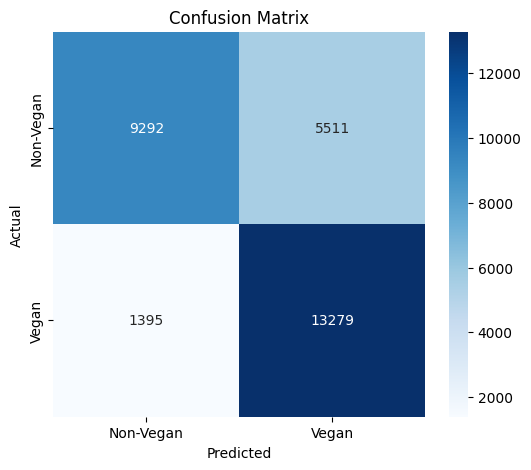

In [15]:
# Predict on the test set
y_pred = svm_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Non-Vegan", "Vegan"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Vegan", "Vegan"], yticklabels=["Non-Vegan", "Vegan"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [16]:
# Save the SVM model
joblib.dump(svm_model, "svm_model.pkl")

['svm_model.pkl']